In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import block_diag
sns.set_theme(style="darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.vae_models import CVAE
import src.experiment_lib as experiment_lib
from src.forecasting_metrics import *

In [4]:
config_dir = 'runs/forecast/'
config_folder = 'sweep_Nov29_16-39-01/'
config = json.load(open(config_dir + config_folder +'config.json', 'r'))

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=1000
Mean of enrolments: 0.31
Number of Training Points...............1493743
Number of Testing Points................498590
Number of Validation Points.............498455
Number of Missing Points.................2162
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_44


In [6]:
num_users = user_ids["train"][-1]+1

In [7]:
model = CVAE(input_dim=trainset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(os.path.join(config_dir, config_folder))
model.eval()

USING SIGMA_LIM!
USING SIGMA_LIM!


CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=152, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=1000, out_features=1000, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=1000, out_features=1000, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (mu): NNBlock(
          (input_layer): Sequential(
            (0

In [8]:
torch.cuda.empty_cache()
import gc
gc.collect()

30

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.prior_params = {key: value.to(device) for key, value in model.prior_params.items()}

In [10]:
log_space = config["data"]["scaling"]["log_space"]
zero_id = config["data"]["scaling"]["zero_id"]
shift = config["data"]["scaling"]["shift"]

In [11]:
test_conditions = torch.tensor(conditioner.transform(condition_set["test"])).float()

In [12]:
num_test_days = int(X_test.shape[0]/num_users)

In [22]:
num_prior_samples = 1000
test_batch_size = 2**8
num_batches = int(np.ceil(test_conditions.shape[0] / test_batch_size))
estimation_params = {"mu":torch.zeros(num_prior_samples, num_users*num_test_days, model.input_dim), "sigma":torch.zeros(num_prior_samples, num_users*num_test_days, model.decoder.parameterizer.block_dict["sigma"].output_dim)}
estimation_samples = torch.zeros(num_prior_samples, num_users*num_test_days, model.input_dim)
log_likelihoods = torch.zeros(num_prior_samples, num_users*num_test_days)


In [23]:
flag=False

In [24]:
pbar = tqdm(total=X_test.shape[0]*num_prior_samples)

for i in range(num_batches):
    
    if i == num_batches-1: batch_indices = np.arange(i*test_batch_size, test_conditions.shape[0], dtype=int)
    else: batch_indices = np.arange(i*test_batch_size, (i+1)*test_batch_size, dtype=int)

    # batch_conditions = test_conditions[batch_indices]
    x_test = torch.tensor(X_test[batch_indices]).to(device)
    condition_batch = {k: v[batch_indices] for k,v in condition_set["test"].items()}
    
    if flag:
        for j in range(num_prior_samples):
            pbar.update(len(batch_indices))
            with torch.no_grad():
                batch_conditions = torch.tensor(conditioner.transform(condition_batch)).float()
                estimation = model.sample(batch_conditions.to(device), num_samples_prior=1)
                estimation_params["mu"][j, batch_indices] = estimation["params"]["mu"].detach().to("cpu")
                estimation_params["sigma"][j, batch_indices] = estimation["params"]["sigma"].detach().to("cpu")
                estimation_samples[j, batch_indices] = estimation["samples"].detach().squeeze().to("cpu")
                log_likelihoods[j, batch_indices] = model.decoder.log_likelihood(x_test, estimation["params"]).detach().to("cpu").float()
    else:
        pbar.update(len(batch_indices)*num_prior_samples)
        with torch.no_grad():
            estimation = model.sample(test_conditions[batch_indices].to(device), num_samples_prior=num_prior_samples)
            estimation_params["mu"][:, batch_indices] = estimation["params"]["mu"].detach().to("cpu")
            estimation_params["sigma"][:, batch_indices] = estimation["params"]["sigma"].detach().to("cpu")
            estimation_samples[:, batch_indices] = estimation["samples"].detach().squeeze().to("cpu")
            log_likelihoods[:, batch_indices] = model.decoder.log_likelihood(x_test, estimation["params"]).detach().to("cpu").float()

  0%|          | 0/124647500 [00:00<?, ?it/s]

In [25]:
estimation_params["mu"] = estimation_params["mu"].numpy()
estimation_params["sigma"] = estimation_params["sigma"].numpy()
estimation_samples = estimation_samples.numpy()
log_likelihoods = log_likelihoods.numpy()

In [26]:
log_likelihoods = log_likelihoods.reshape(num_prior_samples, num_users, num_test_days)

In [27]:
closest_idx = np.argsort(log_likelihoods, axis=0)[::-1]

In [62]:
quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

In [63]:
estimation_samples_denorm = utils.zero_preserved_log_denormalize(np.maximum(estimation_samples,zero_id), nonzero_mean, nonzero_std, log_input=log_space).reshape(num_prior_samples,num_users,-1)

In [64]:
estimation_params_denorm = {}
estimation_params_denorm["mu"] = utils.zero_preserved_log_denormalize(estimation_params["mu"], nonzero_mean, nonzero_std, log_input=log_space).reshape(num_prior_samples,num_users,-1)

estimation_params["mu"] = estimation_params["mu"].reshape(num_prior_samples,num_users,-1,model.input_dim)
estimation_params["sigma"] = estimation_params["sigma"].reshape(num_prior_samples,num_users,-1,model.decoder.parameterizer.block_dict["sigma"].output_dim)

KeyboardInterrupt: 

In [31]:
quantiles_test = np.quantile(np.maximum(estimation_samples,zero_id), quantiles, axis=0)
quantiles_test_denorm = utils.zero_preserved_log_denormalize(quantiles_test, nonzero_mean, nonzero_std, log_input=log_space)
quantiles_test = quantiles_test.reshape(len(quantiles), num_users, -1)
quantiles_test_denorm = quantiles_test_denorm.reshape(len(quantiles), num_users, -1)

In [32]:
X_test_denorm = utils.zero_preserved_log_denormalize(X_test, nonzero_mean, nonzero_std, log_input=log_space).reshape(user_ids["train"][-1]+1,-1)

In [33]:
user_idx = 550
start_day = 13
end_day = 28

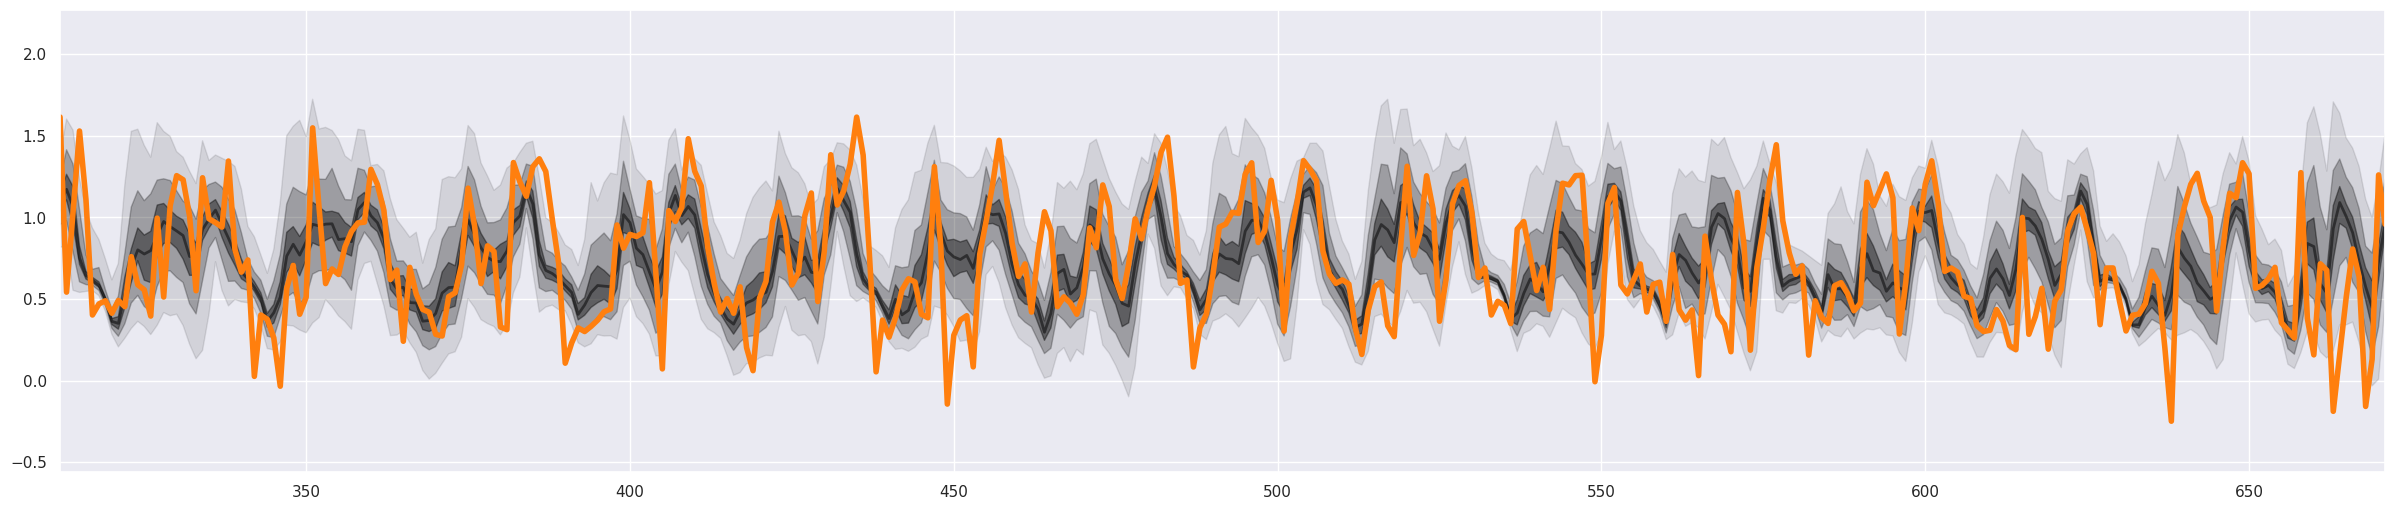

In [ ]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test.shape[-1]),quantiles_test[i,user_idx,:], quantiles_test[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test.reshape(num_users,-1)[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.plot(np.concatenate((X_test.reshape(num_users,-1)[user_idx][-24:], X_test.reshape(num_users,-1)[user_idx][:-24])), label="True", lw=4, alpha=1.0, color="tab:orange") 
# ax.set_yscale("log")

plt.xlim(24*start_day, 24*end_day-1)
plt.show()

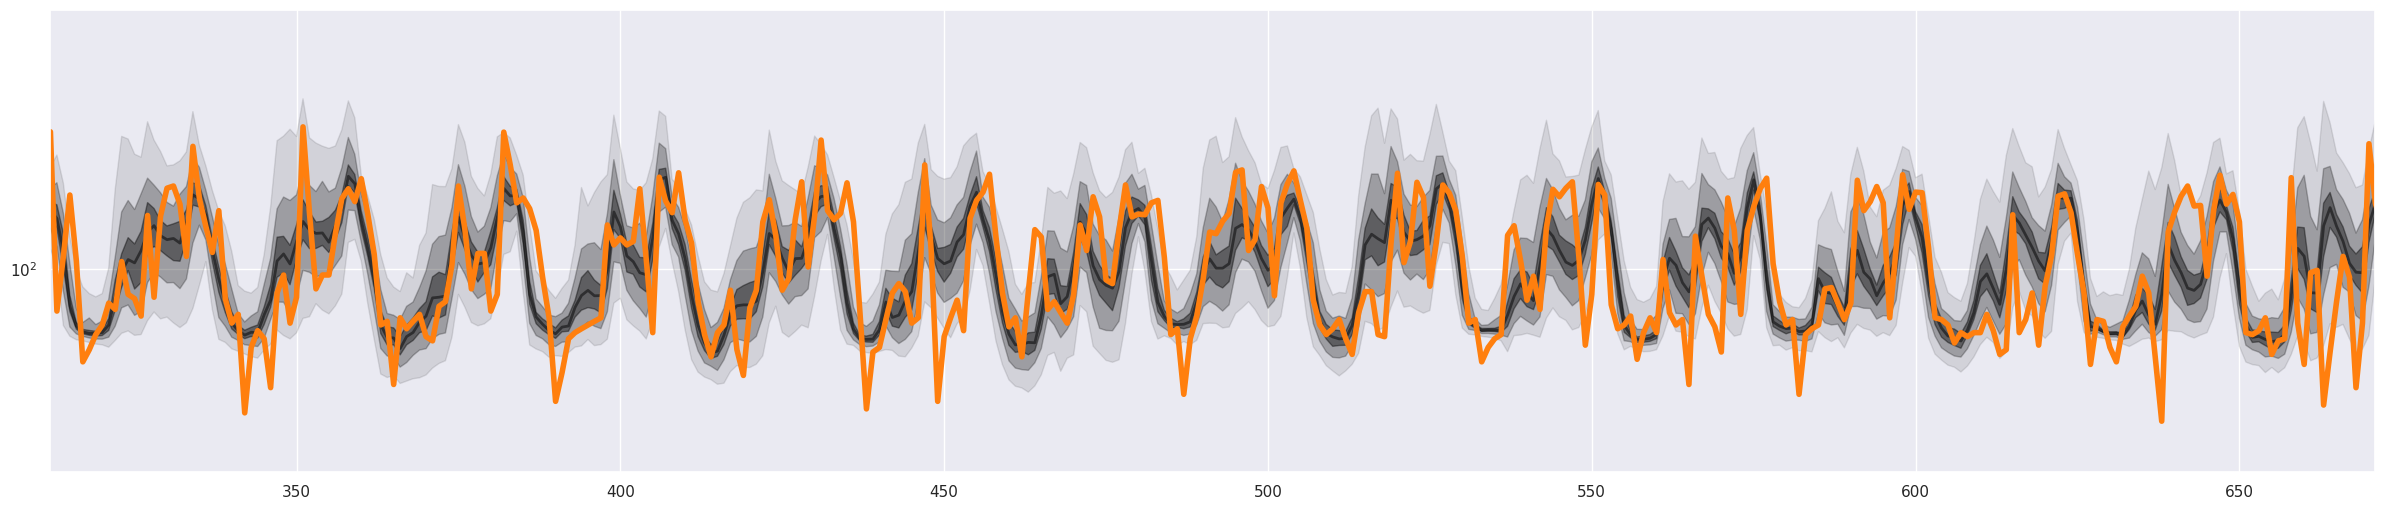

In [ ]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[i,user_idx,:], quantiles_test_denorm[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test_denorm[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test_denorm[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.plot(np.concatenate((X_test_denorm[user_idx][-24:], X_test_denorm[user_idx][:-24])), label="True", lw=4, alpha=1.0, color="tab:orange") 
ax.set_yscale("log")

plt.xlim(24*start_day, 24*end_day-1)
plt.show()

In [36]:
quantile_loss, quantile_losses = calculate_quantile_loss(X_test_denorm, quantiles_test_denorm, quantiles)
coverage_score, coverage_scores = calculate_coverage_score(X_test_denorm, quantiles_test_denorm, quantiles)
interval_score, interval_scores, iqrs = calculate_interval_score(X_test_denorm, quantiles_test_denorm, quantiles)
interval_coverage_score, interval_coverage_scores, iqrs = calculate_interval_coverage_score(X_test_denorm, quantiles_test_denorm, quantiles)
mean_absolute_dev, mean_absolute_devs = calculate_mean_absolute_deviation(X_test_denorm, quantiles_test_denorm, quantiles)

In [37]:
results_dict = {"sample_flag": flag, "results": {"quantile_loss":quantile_loss, "mean_absolute_dev":mean_absolute_dev, "coverage_score":coverage_score, "interval_score":interval_score, "interval_coverage_score":interval_coverage_score}}

In [38]:
df_results = pd.DataFrame(results_dict["results"], index=[0])

In [ ]:
df_results.loc[0]

quantile_loss               56.151038
mean_absolute_dev          162.219241
coverage_score               0.045121
interval_score             942.553942
interval_coverage_score      0.382691
Name: 0, dtype: float64

In [ ]:
df_results.loc[0]

quantile_loss               56.151038
mean_absolute_dev          162.219241
coverage_score               0.045121
interval_score             942.553942
interval_coverage_score      0.382691
Name: 0, dtype: float64

In [41]:
#save results as json to config_dir + config_folder with tabs
with open(os.path.join(config_dir, config_folder, f"results_forecasting.json"), 'w') as f:
    json.dump(results_dict, f, indent=4)

In [42]:
num_viz_samples = 1
best_indices = closest_idx[:num_viz_samples,user_idx,:]
median_best_indices = closest_idx[(num_prior_samples-num_viz_samples)//2:(num_prior_samples+num_viz_samples)//2,user_idx,:]

In [43]:
with torch.no_grad():
    cov_matrices_median = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:,user_idx], median_best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    cov_matrices_best = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:,user_idx], best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    marginal_sigmas_median = np.sqrt(np.diagonal(cov_matrices_median, axis1=-2, axis2=-1))
    marginal_sigmas_best = np.sqrt(np.diagonal(cov_matrices_best, axis1=-2, axis2=-1))
    corr_matrices_median = cov_matrices_median / (marginal_sigmas_median[...,:,None,:] * marginal_sigmas_median[...,None])
    corr_matrices_best = cov_matrices_best / (marginal_sigmas_best[...,:,None,:] * marginal_sigmas_best[...,None])

In [44]:
devs = [ 1, 1.5, 2 ]

dependency_lookaway = 7

In [45]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.4)

/tmp/ipykernel_2673117/2675253126.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar


FileNotFoundError: [Errno 2] No such file or directory: '/home/kbolat/Python/behavio-temporal-vae/transfer/forecasting/output.png'

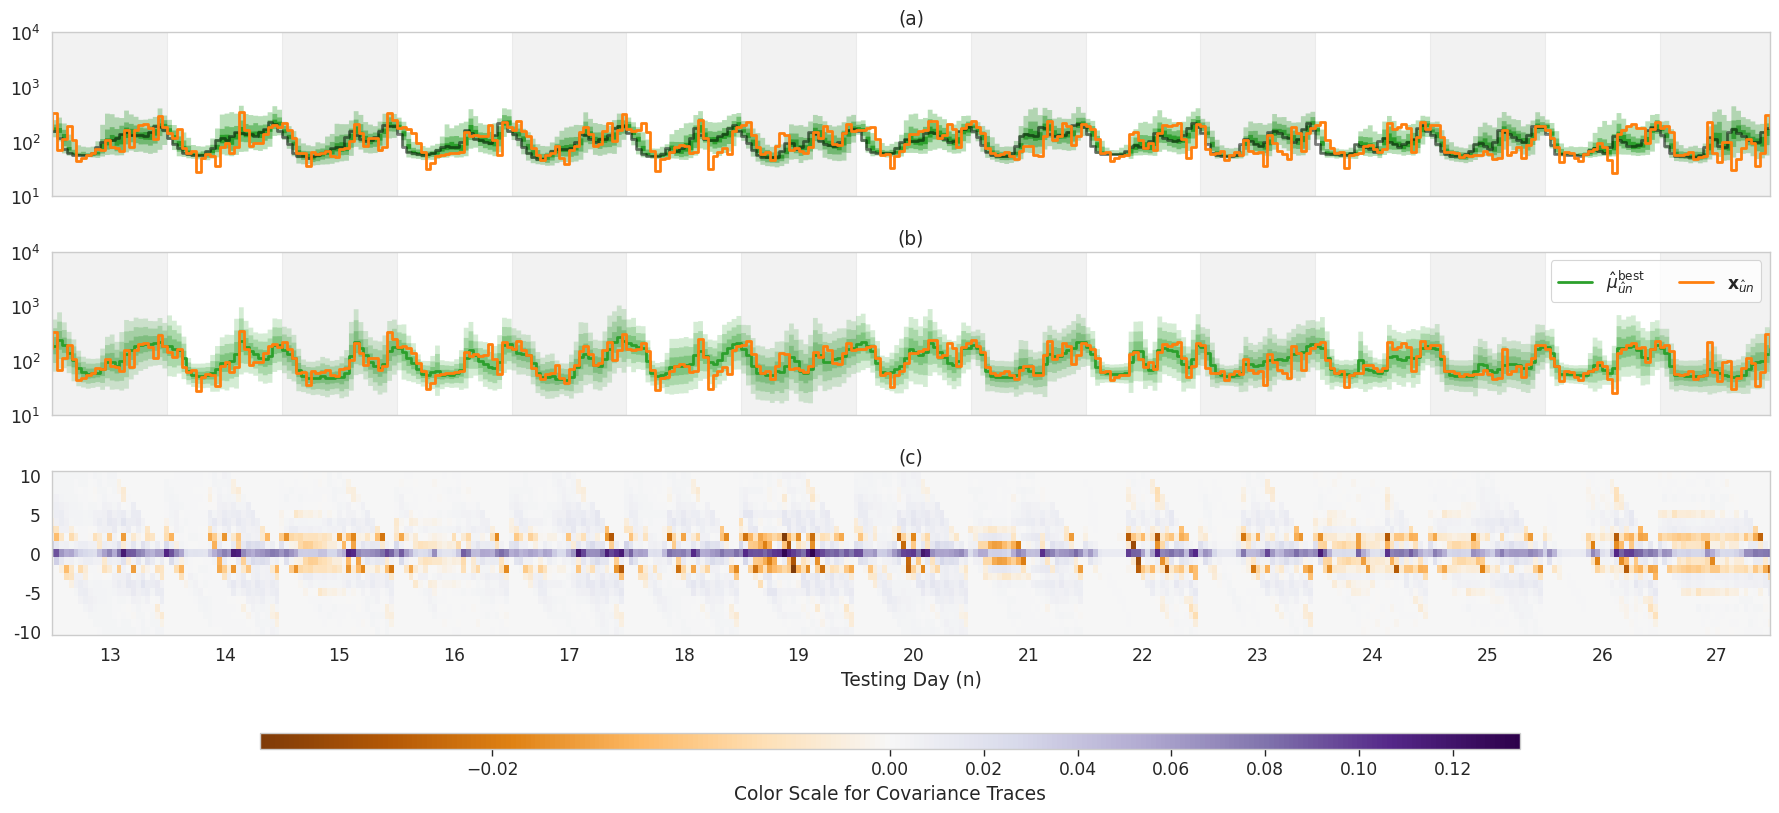

In [ ]:
fig, ax = plt.subplots(3,figsize=(18, 8), sharex=True)
# fig.tight_layout()

for i in range(num_viz_samples):

    for i in range(quantiles.__len__()//2):
        ax[0].fill_between(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[i,user_idx,:], quantiles_test_denorm[-(i+1),user_idx,:], alpha=1/((1-i)+2), color="tab:green", lw=0, step="post")
    ax[0].step(np.arange(quantiles_test_denorm.shape[-1]),quantiles_test_denorm[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)

    ax[0].step(np.arange(X_test_denorm[user_idx].shape[0]), X_test_denorm[user_idx], where="post", lw=2, alpha=1.0, color="tab:orange", label=r"$\mathbf{x}_{\hat{u}n}$")

for i in range(num_viz_samples):
    selected_mu_denorm = np.take_along_axis(estimation_params_denorm["mu"][:,user_idx].reshape(num_prior_samples,num_test_days,-1), best_indices[[i]][...,None], axis=0)
    selected_mu = np.take_along_axis(estimation_params["mu"][:,user_idx], best_indices[[i]][...,None], axis=0)

    # ax[0].plot(selected_mu_denorm.reshape(-1), label="Best estimation", lw=2, alpha=1, color="tab:green")
    ax[1].step(np.arange(selected_mu_denorm.reshape(-1).shape[0]), selected_mu_denorm.reshape(-1), where="post", lw=2, alpha=1, color="tab:green", label=r"$\hat{\mu}_{\hat{u}n}^{\text{best}}$")
    for dev in devs:
        lower_bound = utils.zero_preserved_log_denormalize(selected_mu-dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        upper_bound = utils.zero_preserved_log_denormalize(selected_mu+dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        ax[1].fill_between(np.arange(lower_bound.shape[-1]), lower_bound, upper_bound, alpha=1/(dev+2), color="tab:green", lw=0, step="post")
    
    # ax[i].plot(X_test_denorm[user_idx], label="Ground truth", lw=3, alpha=1.0, color="tab:orange")
    ax[1].step(np.arange(X_test_denorm[user_idx].shape[0]), X_test_denorm[user_idx], where="post", lw=2, alpha=1.0, color="tab:orange", label=r"$\mathbf{x}_{\hat{u}n}$")
    ax[1].legend(loc="upper right", ncol=2)

#put a gray background every 24 hours
for i in [0,1]:
    for j in range(start_day, end_day,2): ax[i].axvspan(24*j, 24*(j+1), color="gray", alpha=0.1)

# Create a common colormap normalization for both imshows
cmap = "PuOr"
norm = mcolors.TwoSlopeNorm(vcenter=0)

# Plot the imshow for axes 1 and 3
im = ax[2].imshow(utils.full_band(block_diag(*[cov_matrices_best[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), 
                   cmap=cmap, aspect="auto", interpolation="nearest", norm=norm)

# Set y-ticks for axes 1 and 3
ax[2].set_yticks(np.arange(0, 2*dependency_lookaway + 1, 5))
ax[2].set_yticklabels(np.arange(-dependency_lookaway, dependency_lookaway + 1, 5)[::-1])

# Add a single horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Color Scale for Covariance Traces")

# Update axis labels and layout
ax[-1].set_xticks(np.arange(12, num_test_days * 24, 24))
ax[-1].set_xticklabels(np.arange(0, num_test_days, 1))

for i in [0,1]:
    ax[i].set_yscale("log")
    ax[i].set_ylim(1e1, 1e4)

titles = ["(a)", "(b)", "(c)", "(d)"]

for i, ax_ in enumerate(ax):
    ax_.set_xlim(24 * start_day, 24 * end_day - 1)
    ax_.grid(False)
    ax_.set_title(titles[i])

ax[-1].set_xlabel("Testing Day (n)")
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar

plt.savefig("transfer/forecasting/output.png", dpi=300, bbox_inches="tight")

plt.show()

/tmp/ipykernel_2673117/1938908062.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar


FileNotFoundError: [Errno 2] No such file or directory: '/home/kbolat/Python/behavio-temporal-vae/transfer/forecasting/output.png'

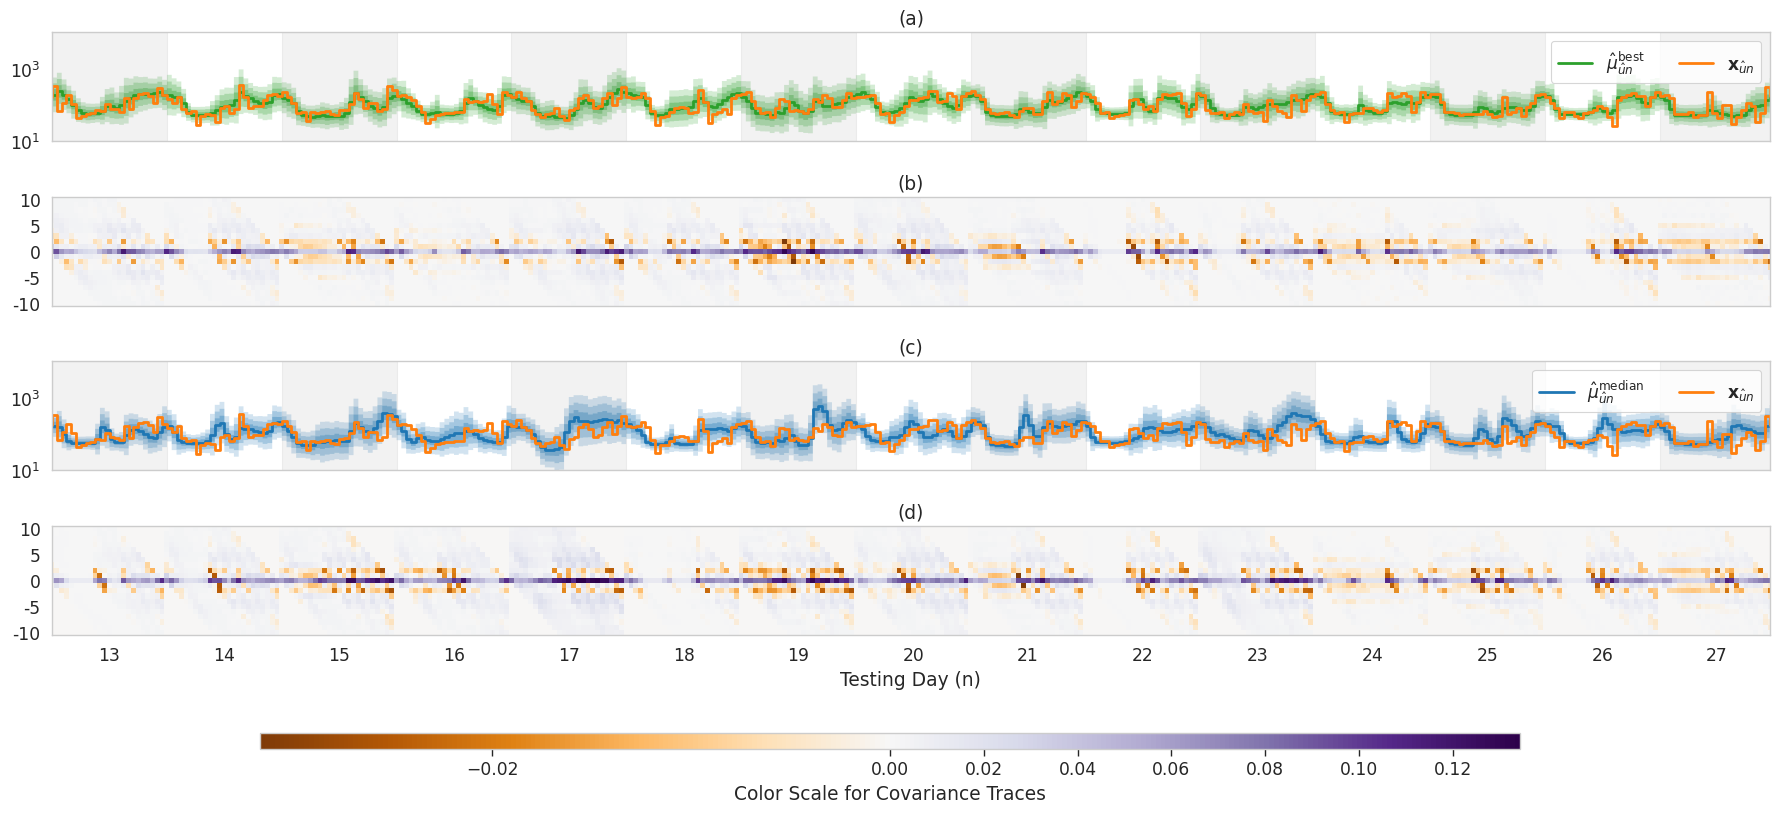

In [ ]:
fig, ax = plt.subplots(4,figsize=(18, 8), sharex=True)
# fig.tight_layout()

for i in range(num_viz_samples):
    selected_mu_denorm = np.take_along_axis(estimation_params_denorm["mu"][:,user_idx].reshape(num_prior_samples,num_test_days,-1), best_indices[[i]][...,None], axis=0)
    selected_mu = np.take_along_axis(estimation_params["mu"][:,user_idx], best_indices[[i]][...,None], axis=0)

    # ax[0].plot(selected_mu_denorm.reshape(-1), label="Best estimation", lw=2, alpha=1, color="tab:green")
    ax[0].step(np.arange(selected_mu_denorm.reshape(-1).shape[0]), selected_mu_denorm.reshape(-1), where="post", lw=2, alpha=1, color="tab:green", label=r"$\hat{\mu}_{\hat{u}n}^{\text{best}}$")
    for dev in devs:
        lower_bound = utils.zero_preserved_log_denormalize(selected_mu-dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        upper_bound = utils.zero_preserved_log_denormalize(selected_mu+dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        ax[0].fill_between(np.arange(lower_bound.shape[-1]), lower_bound, upper_bound, alpha=1/(dev+2), color="tab:green", lw=0, step="post")
    
    selected_mu_denorm = np.take_along_axis(estimation_params_denorm["mu"][:,user_idx].reshape(num_prior_samples,num_test_days,-1), median_best_indices[[i]][...,None], axis=0)
    selected_mu = np.take_along_axis(estimation_params["mu"][:,user_idx], median_best_indices[[i]][...,None], axis=0)
    # ax[2].plot(selected_mu_denorm.reshape(-1), label="Median-Best estimation", lw=2, alpha=1, color="tab:blue")
    ax[2].step(np.arange(selected_mu_denorm.reshape(-1).shape[0]), selected_mu_denorm.reshape(-1), where="post", lw=2, alpha=1, color="tab:blue", label=r"$\hat{\mu}_{\hat{u}n}^{\text{median}}$")
    for dev in devs:
        lower_bound = utils.zero_preserved_log_denormalize(selected_mu-dev*marginal_sigmas_median[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        upper_bound = utils.zero_preserved_log_denormalize(selected_mu+dev*marginal_sigmas_median[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        ax[2].fill_between(np.arange(lower_bound.shape[-1]), lower_bound, upper_bound, alpha=1/(dev+2), color="tab:blue", lw=0, step="post")
    
for i in [0,2]: 
    # ax[i].plot(X_test_denorm[user_idx], label="Ground truth", lw=3, alpha=1.0, color="tab:orange")
    ax[i].step(np.arange(X_test_denorm[user_idx].shape[0]), X_test_denorm[user_idx], where="post", lw=2, alpha=1.0, color="tab:orange", label=r"$\mathbf{x}_{\hat{u}n}$")
    ax[i].legend(loc="upper right", ncol=2)
    #put a gray background every 24 hours
    for j in range(start_day, end_day,2): ax[i].axvspan(24*j, 24*(j+1), color="gray", alpha=0.1)

# Create a common colormap normalization for both imshows
cmap = "PuOr"
norm = mcolors.TwoSlopeNorm(vcenter=0)

# Plot the imshow for axes 1 and 3
im1 = ax[1].imshow(utils.full_band(block_diag(*[cov_matrices_best[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), 
                   cmap=cmap, aspect="auto", interpolation="nearest", norm=norm)
im3 = ax[3].imshow(utils.full_band(block_diag(*[cov_matrices_median[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), 
                   cmap=cmap, aspect="auto", interpolation="nearest", norm=norm)

# Set y-ticks for axes 1 and 3
for i in [1, 3]:
    ax[i].set_yticks(np.arange(0, 2*dependency_lookaway + 1, 5))
    ax[i].set_yticklabels(np.arange(-dependency_lookaway, dependency_lookaway + 1, 5)[::-1])

# Add a single horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im3, cax=cbar_ax, orientation="horizontal", label="Color Scale for Covariance Traces")

# Update axis labels and layout
ax[-1].set_xticks(np.arange(12, num_test_days * 24, 24))
ax[-1].set_xticklabels(np.arange(0, num_test_days, 1))

for i in [0, 2]:
    ax[i].set_yscale("log")
    ax[i].set_ylim(1e1, 1e4)

titles = ["(a)", "(b)", "(c)", "(d)"]

for i, ax_ in enumerate(ax):
    ax_.set_xlim(24 * start_day, 24 * end_day - 1)
    ax_.grid(False)
    ax_.set_title(titles[i])

ax[-1].set_xlabel("Testing Day (n)")
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar

plt.savefig("transfer/forecasting/output.png", dpi=300, bbox_inches="tight")

plt.show()

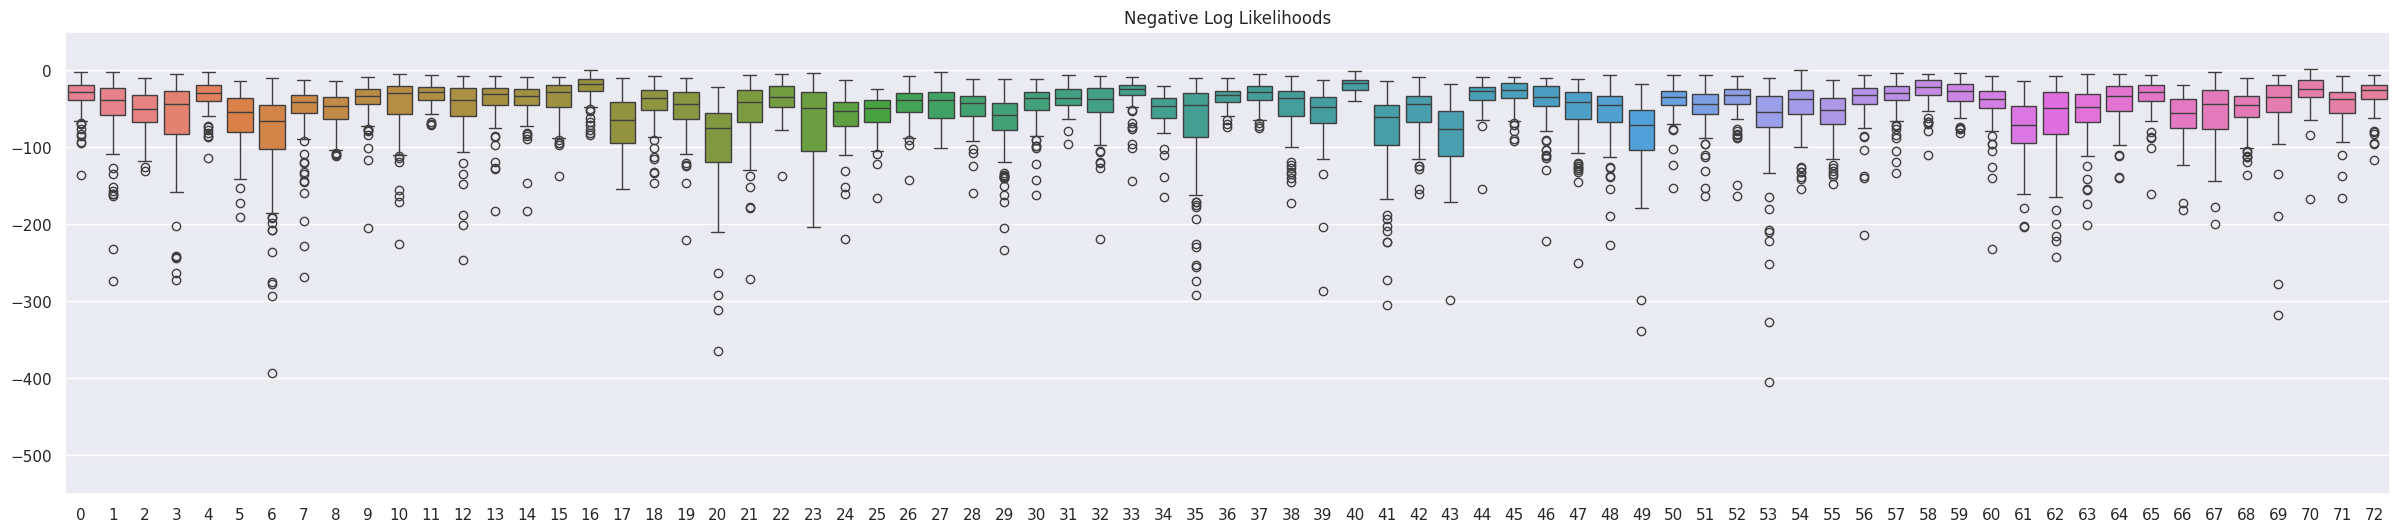

In [37]:
fig, ax = plt.subplots(figsize=(30, 6))
sns.boxplot(log_likelihoods[:,user_idx], ax=ax, log_scale=False)
ax.set_title("Negative Log Likelihoods")
# ax.set_xlim(start_day-.5, end_day-1+.5)
ax.set_ylim(-550, 50)
plt.show()

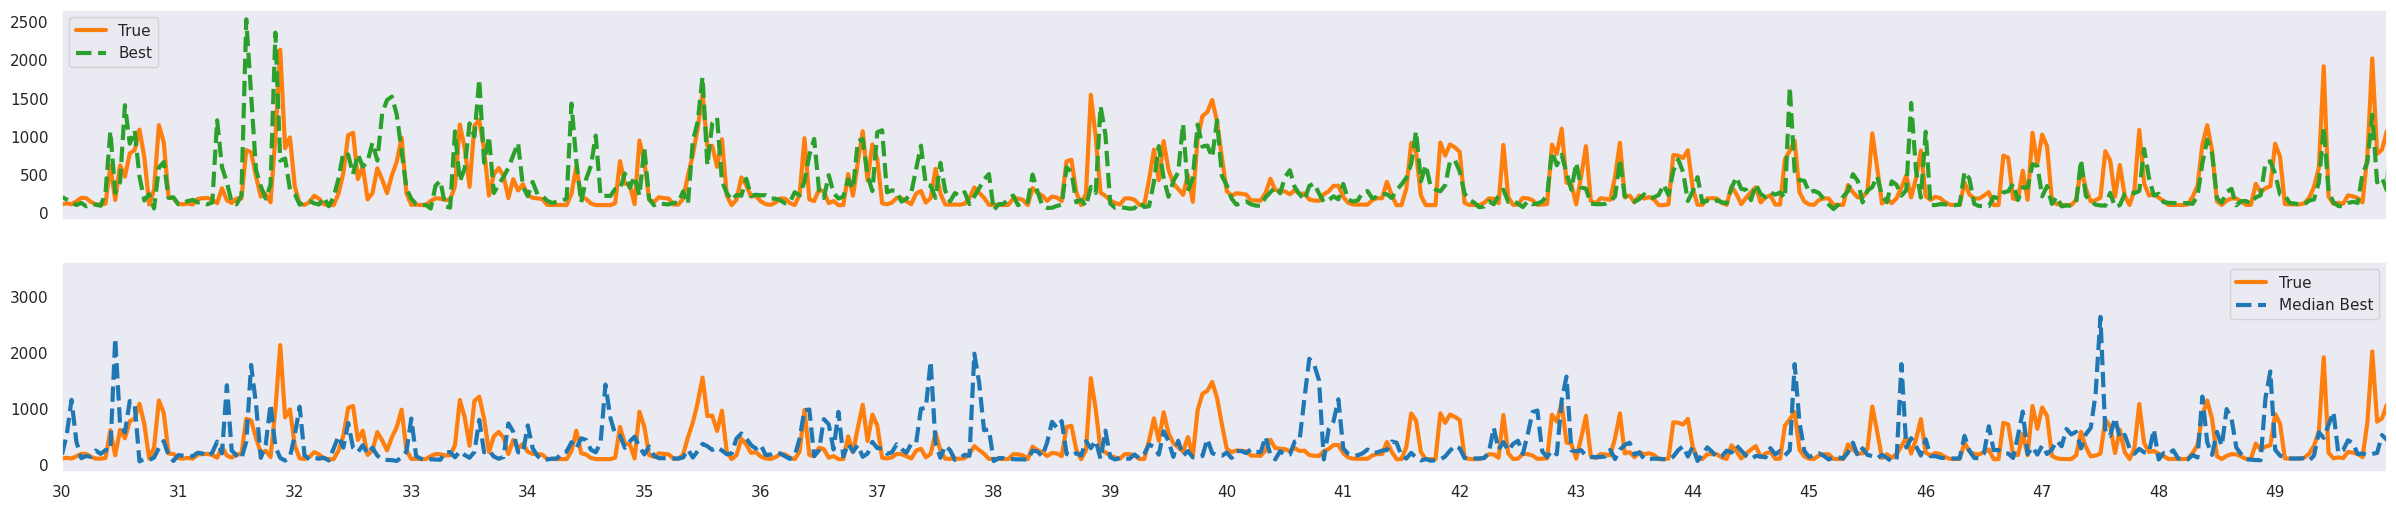

In [38]:
fig, ax = plt.subplots(2,figsize=(30, 6), sharex=True)

ax[0].plot(X_test_denorm[user_idx], label="True", lw=3, color="tab:orange")
ax[0].plot(np.take_along_axis(estimation_samples_denorm[:,user_idx,:].reshape(num_prior_samples,num_test_days,-1), best_indices[...,None], axis=0).reshape(num_viz_samples,-1).T, label="Best", lw=3, alpha=1.0, color="tab:green", linestyle="--")
ax[0].set_xticks(np.arange(0, num_test_days*24, 24))
ax[0].set_xticklabels(np.arange(0, num_test_days, 1))
ax[0].legend()
# ax[0].set_yscale("log")

ax[1].plot(X_test_denorm[user_idx], label="True", lw=3, color="tab:orange")
ax[1].plot(np.take_along_axis(estimation_samples_denorm[:,user_idx,:].reshape(num_prior_samples,num_test_days,-1), median_best_indices[...,None], axis=0).reshape(num_viz_samples,-1).T, label="Median Best", lw=3, alpha=1.0, color="tab:blue", linestyle="--")
ax[1].set_xticks(np.arange(0, num_test_days*24, 24))
ax[1].set_xticklabels(np.arange(0, num_test_days, 1))
ax[1].legend()
# ax[1].set_yscale("log")

# ax[0].set_ylim(-100, 6000)
# ax[1].set_ylim(-100, 6000)
plt.xlim(24*start_day, 24*end_day-1)
ax[0].grid(False)
ax[1].grid(False)
plt.show()

In [39]:
from scipy.interpolate import *

interpolator = PchipInterpolator

UPSCALE_FACTOR = 10
tnew = np.linspace(0, X_test_denorm.shape[1], X_test_denorm.shape[1]*UPSCALE_FACTOR)

In [40]:
spl = interpolator(np.arange(X_test_denorm[user_idx].shape[0]), X_test_denorm[user_idx])
X_smooth = spl(tnew)

spl = interpolator(np.arange(X_test_denorm[user_idx].shape[0]), np.take_along_axis(estimation_samples_denorm[:,user_idx,:].reshape(num_prior_samples,num_test_days,-1), best_indices[...,None], axis=0).reshape(num_viz_samples,-1).T)
X_smooth_best = spl(tnew)

spl = interpolator(np.arange(X_test_denorm[user_idx].shape[0]), np.take_along_axis(estimation_samples_denorm[:,user_idx,:].reshape(num_prior_samples,num_test_days,-1), median_best_indices[...,None], axis=0).reshape(num_viz_samples,-1).T)
X_smooth_median_best = spl(tnew)

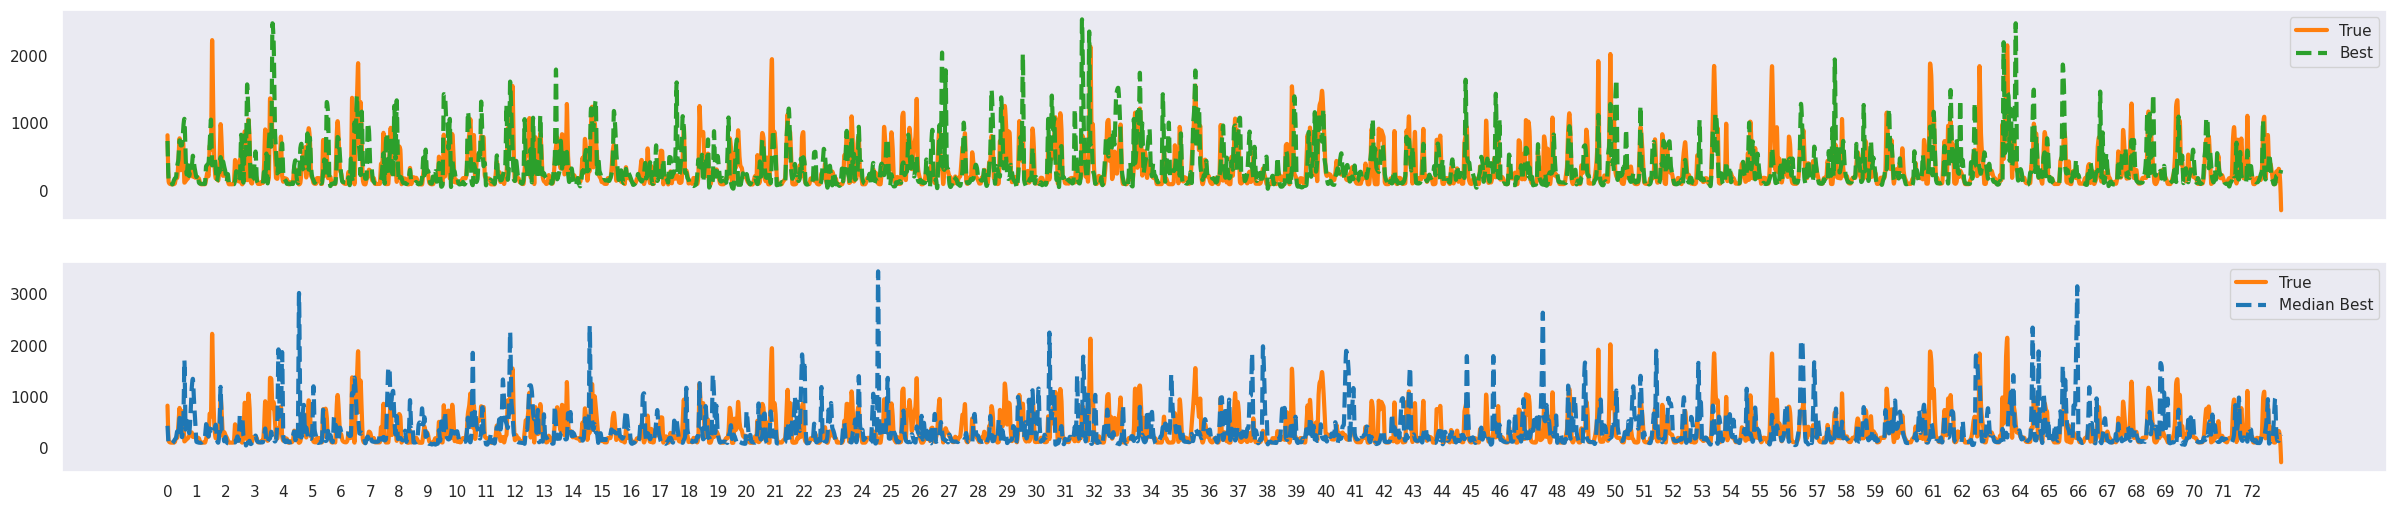

In [41]:
fig, ax = plt.subplots(2,figsize=(30, 6), sharex=True)

ax[0].plot(X_smooth, label="True", lw=3, color="tab:orange")
ax[0].plot(X_smooth_best, label="Best", lw=3, alpha=1.0, color="tab:green", linestyle="--")
ax[0].set_xticks(np.arange(0, num_test_days*24*UPSCALE_FACTOR, 24*UPSCALE_FACTOR))
ax[0].set_xticklabels(np.arange(0, num_test_days, 1))
ax[0].legend()
# ax[0].set_yscale("log")

ax[1].plot(X_smooth, label="True", lw=3, color="tab:orange")
ax[1].plot(X_smooth_median_best, label="Median Best", lw=3, alpha=1.0, color="tab:blue", linestyle="--")
ax[1].set_xticks(np.arange(0, num_test_days*24*UPSCALE_FACTOR, 24*UPSCALE_FACTOR))
ax[1].set_xticklabels(np.arange(0, num_test_days, 1))
ax[1].legend()
# ax[1].set_yscale("log")

# ax[0].set_ylim(-100, 6000)
# ax[1].set_ylim(-100, 6000)
# plt.xlim(24*UPSCALE_FACTOR*start_day, 24*UPSCALE_FACTOR*end_day-1)
ax[0].grid(False)
ax[1].grid(False)
plt.show()

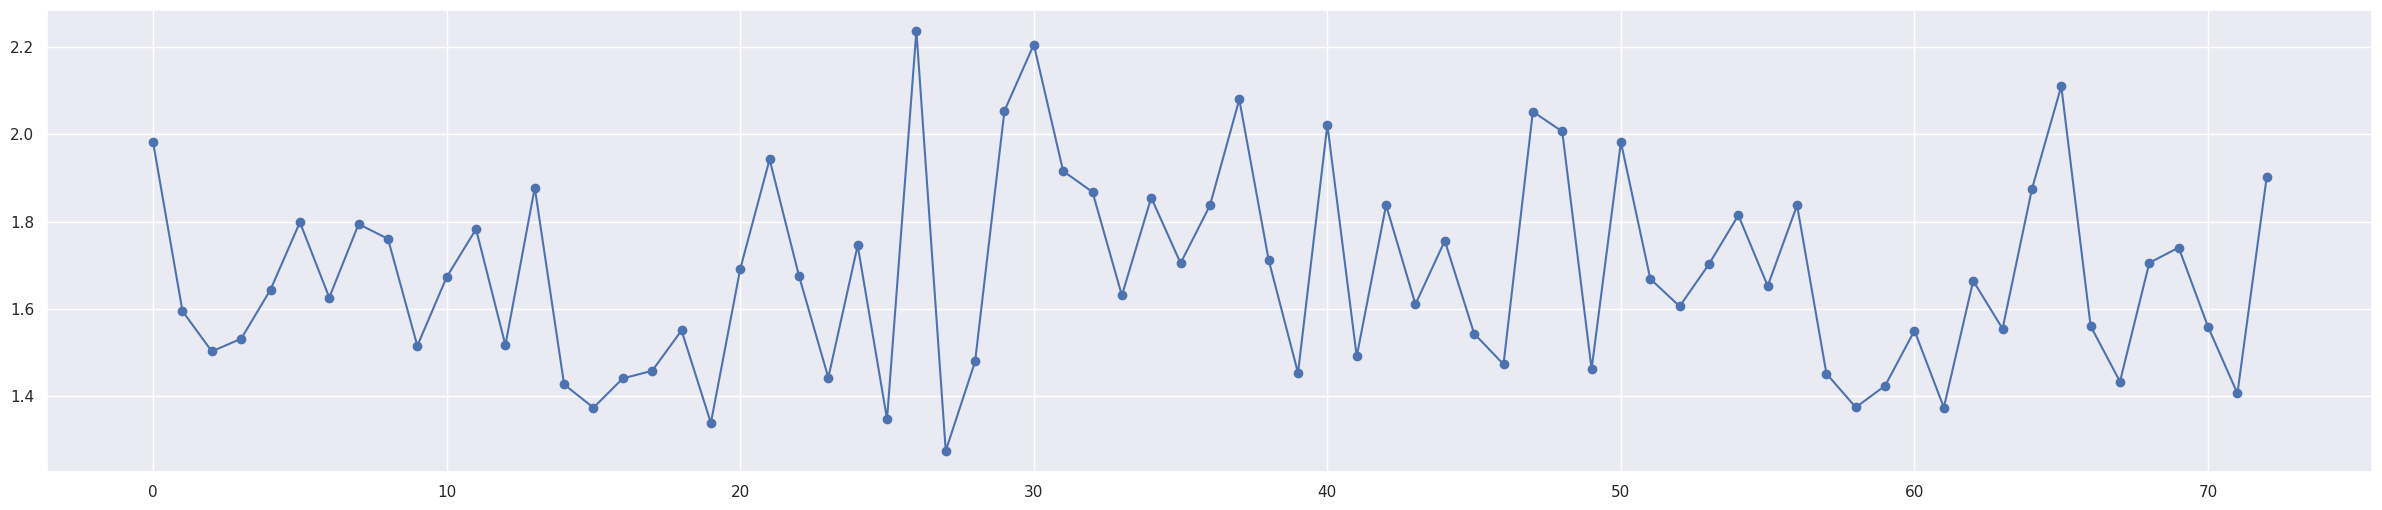

In [42]:
fig, ax = plt.subplots(figsize=(30, 6))
plt.plot((np.trace(cov_matrices_median, axis1=-1, axis2=-2)**.5).T, marker='o')

In [43]:
estimation_params_aggregated = {}
estimation_params_aggregated["mu"] = np.mean(estimation_params_denorm["mu"], axis=1).reshape(num_prior_samples,num_test_days,-1)
agg_mu_normalized = utils.zero_preserved_log_normalize(estimation_params_aggregated["mu"], nonzero_mean, nonzero_std, log_output=log_space).reshape(num_prior_samples,num_test_days,-1)
estimation_params_aggregated["sigma"] = np.sqrt(np.sum(estimation_params["sigma"]**2, axis=1)) * 1/num_prior_samples**2
with torch.no_grad():
    covariance_matrix_aggregated = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params_aggregated["mu"]).to(device), "sigma": torch.tensor(estimation_params_aggregated["sigma"]).to(device)}).cpu().numpy()
    marginal_sigmas_aggregated = np.sqrt(np.diagonal(covariance_matrix_aggregated, axis1=-2, axis2=-1))


In [44]:
X_test_aggregated = np.mean(X_test_denorm, axis=0)

In [45]:
prior_sample_idx = 0

NameError: name 'full_band' is not defined

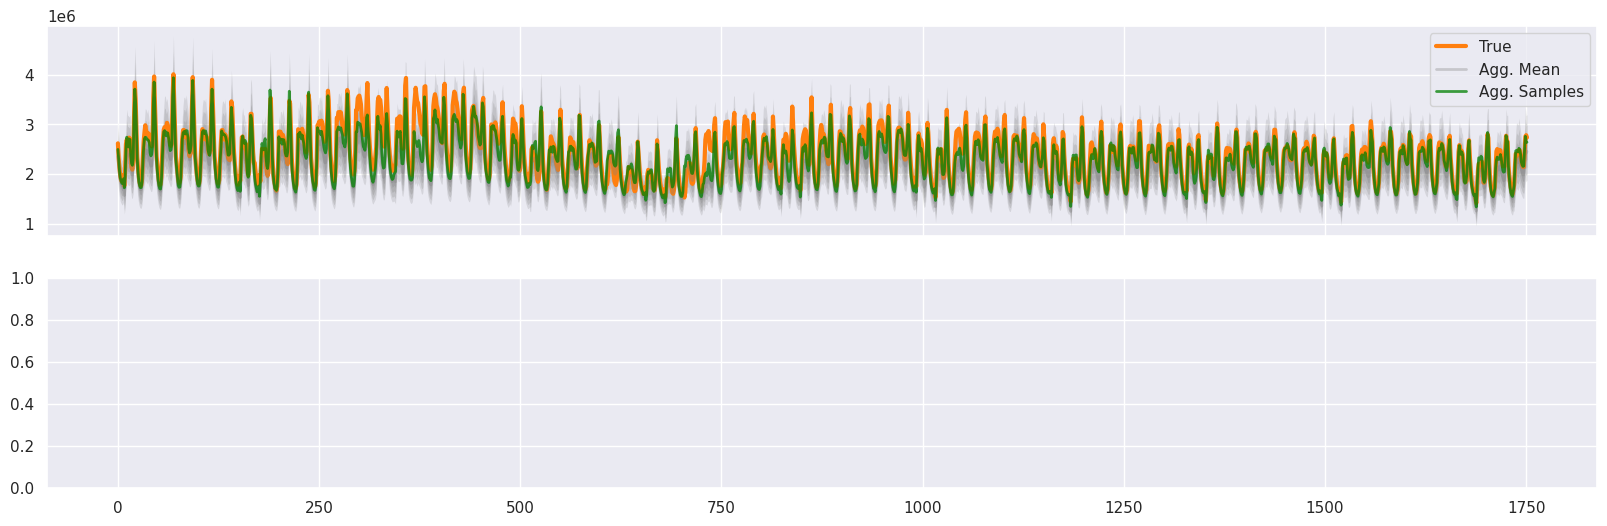

In [46]:
fig, ax = plt.subplots(2, figsize=(20, 6), sharex=True)

ax[0].plot(X_test_aggregated*num_users, label="True", lw=3, alpha=1.0, color="tab:orange")
ax[0].plot(estimation_params_aggregated["mu"][0].reshape(-1)*num_users, label="Agg. Mean", color="tab:gray", lw=2, alpha=1/3)
ax[0].plot(estimation_samples_denorm[prior_sample_idx].sum(0).reshape(-1), label="Agg. Samples", color="green", lw=2, alpha=0.75)

for dev in devs:
    upper_bound_aggregated = utils.zero_preserved_log_denormalize(agg_mu_normalized[prior_sample_idx]+dev*marginal_sigmas_aggregated[prior_sample_idx], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)*num_users
    lower_bound_aggregated = utils.zero_preserved_log_denormalize(agg_mu_normalized[prior_sample_idx]-dev*marginal_sigmas_aggregated[prior_sample_idx], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)*num_users
    ax[0].fill_between(np.arange(lower_bound_aggregated.shape[-1]), lower_bound_aggregated, upper_bound_aggregated, alpha=1/(dev+3), color="tab:gray", lw=0)

# ax[0].set_yscale("log")
ax[0].legend()

ax[1].imshow(full_band(block_diag(*[covariance_matrix_aggregated[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), cmap="PuOr", aspect="auto", interpolation="nearest", norm=mcolors.TwoSlopeNorm(vcenter=0))

ax[1].set_yticks(np.arange(0,2*dependency_lookaway+1,5))
ax[1].set_yticklabels(np.arange(-dependency_lookaway, dependency_lookaway+1, 5)[::-1])

ax[-1].set_xticks(np.arange(0, num_test_days*24, 24))
ax[-1].set_xticklabels(np.arange(0, num_test_days, 1))

for ax_ in ax:
    ax_.set_xlim(24*start_day, 24*end_day-1)
    ax_.grid(False)
